## Your task

Your task is to use RDD to estimate the effect of the following events in Quebec:

1. The 20/3/2020 lockdown
2. The reopening of schools on 31/8/2020
3. The 25/12/2020 lockdown

### Requirements

You need to find data on at least one COVID measure for `y` (either COVID cases, hospitalizations or deaths) and provide the following for each:

- A RDD plot similar to the ones shown above
- An interpretation of the p-value on the effect of the measure taken (the cutoff parameter)
- A justification on the design of your regression:

  - The amount of time included on both sides of the cutoff (longer is not necessarily better)
  - The polynomial degree (higher is not always better)
  - Other regression design considerations

- A 2 paragraph explanation of your findings for that event.

### Summary
* The p-values of the cutoff parameter itself and other parameters that utilize the cuffoff parameter for all 3 models are all below 0.05, which indicates that they are statistically significant
* Regresion design
    - the amount of time included on both sides of the cutoff is chosen to be within 30 days of the cutoff date. This would ensure that the model will not be skewed by data that are too far away from the date when the measure was taken.
    - the maximum polynomial degree is chosen to be 2 to make sure that the model is not overfitting.
    - a 7-day rolling average centered on date for daily new cases is used to minimize the effect of weekends, holidays and other covid testing variation in general.
    - a lag period after the given event date is used to define the cutoff date because an incubation period for testing positive should be considered
* Major findings
    - **Lockdown measure on 2020/03/20**: This measure is supposed to reduce the rate of increase for daily new cases. Based on our modeling results, the number of daily new cases jumped up slightly right on the cutoff date with a smaller upward trend afterwards. As the slope before and after the cutoff date reduced quite a bit, this could be intepretated as that the lockdown is having some effect on the daily new case count.
    ![Model1](model1.png)
    - **School re-opening on 2020/08/31**: This event could potentially increase the daily new cases dramatically. However, based on our modeling results, the number of daily new cases stays with a almost continous trend after the cutoff date. So we conclude that school re-opening is not having any effect on the daily new case count.
    ![Model2](model2.png)
    - **Lockdown measure on 2020/12/25**: This measure is supposed to reduce the rate of increase for daily new cases. Based on our modeling results, the number of daily new cases jumped up slightly right on the cutoff date but the slope became reversed from postive to negative. This could be intepretated as that the lockdown is having significant effect on the daily new case count.
    ![Model3](model3.png)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import date, timedelta

In [2]:
df = pd.read_csv("COVID19_Qc_RapportINSPQ_HistoVigie.csv", skiprows=[1])

In [3]:
df = df[['Date', 'Nb_Nvx_Cas']]

# change Date column to datatime
df['Date'] = pd.to_datetime(df['Date'])

# shorten the rows so that the dates only go to 2021-04-01
data = df[df['Date']< "2021-04-01"]

# generate 7-day rolling average of new daily COVID-19 cases
data_avg = data.rolling(7, on='Date', center=True).mean() # use the average value of 7 days, value for each date is the mean of values during a period of 7 days centering around this date
data_avg = data_avg.fillna(0)

In [4]:
# visualize the dataset
def plot(df, date1, date2, date3):
    sns.scatterplot(data=df, x='Date', y='Nb_Nvx_Cas', s=6)
    sns.set(rc={'figure.figsize':(8, 4)})
    plt.axvline(date1, color="green")
    plt.axvline(date2, color="green")
    plt.axvline(date3, color="green")
    plt.show()

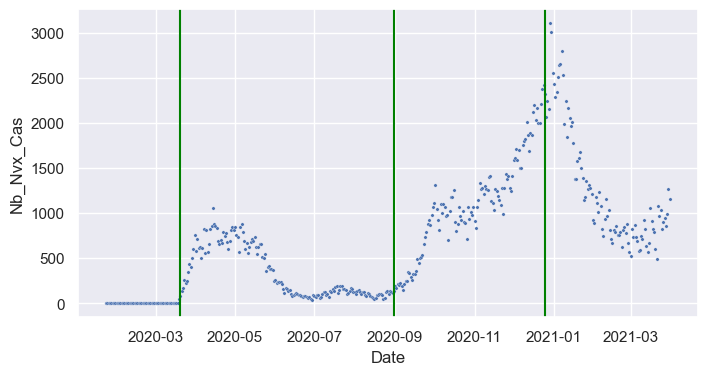

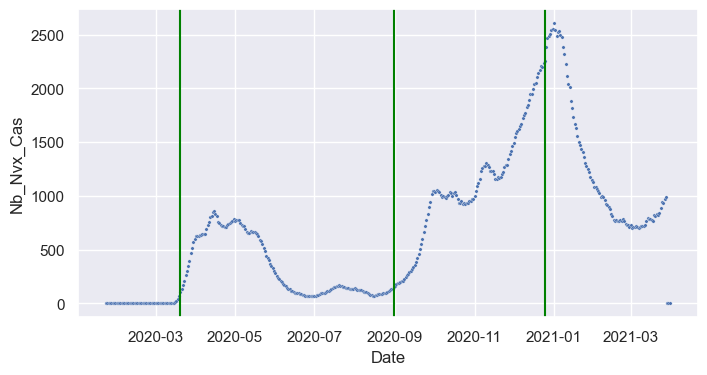

In [17]:
date1 = date(2020, 3, 20) # first lockdown
date2 = date(2020, 8, 31) # school reopening
date3 = date(2020, 12, 25) # second lockdown

plot(data, date1, date2, date3) # original dataset
plot(data_avg, date1, date2, date3) # modified dataset using 7-day rolling average

In [6]:
# define the cutoff date
cutoff1 = date1 + timedelta(days=14) # first lockdown with a 14-day lag
cutoff2 = date2 + timedelta(days=7) # school reopening with 7-day lag
cutoff3 = date3 + timedelta(days=7) # second lockdown with 7-day lag

# define the cutoff variable
data_avg['cutoff'] = 0

# define a period of 30 days before and after cutoff date
after_cutoff1 = pd.date_range(start=cutoff1, periods=30)
after_cutoff2 = pd.date_range(start=cutoff2, periods=30)
after_cutoff3 = pd.date_range(start=cutoff3, periods=30)

# change the cutoff variable to 1 after the cutoff date
data_avg.loc[data_avg['Date'].isin(after_cutoff1),'cutoff'] = 1
data_avg.loc[data_avg['Date'].isin(after_cutoff2),'cutoff'] = 1
data_avg.loc[data_avg['Date'].isin(after_cutoff3),'cutoff'] = 1

# define a period of 30 days before the cutoff date
before_cutoff1 = pd.date_range(end=cutoff1, periods=30, inclusive="left")
before_cutoff2 = pd.date_range(end=cutoff2, periods=30, inclusive="left")
before_cutoff3 = pd.date_range(end=cutoff3, periods=30, inclusive="left")

In [7]:
# create one dataset in the form of (Xi, yi) for each cutoff date
mask1 = data_avg['Date'].isin(before_cutoff1) | data_avg['Date'].isin(after_cutoff1)
X1 = data_avg[mask1][['Date', 'cutoff']]
y1 = data_avg[mask1]['Nb_Nvx_Cas']
y1 = y1.reset_index(drop=True)
X1 = X1.reset_index(drop=True)
X1 = X1.drop('Date', axis=1)
X1 = X1.reset_index(names='daysElapsed') # create the daysElapsed feature and drop the Date column
X1['daysElapsed_cutoff'] = X1['daysElapsed']*X1['cutoff'] # add feature X * c

mask2 = data_avg['Date'].isin(before_cutoff2) | data_avg['Date'].isin(after_cutoff2)
X2 = data_avg[mask2][['Date', 'cutoff']]
y2 = data_avg[mask2]['Nb_Nvx_Cas']
y2 = y2.reset_index(drop=True)
X2 = X2.reset_index(drop=True)
X2 = X2.drop('Date', axis=1)
X2 = X2.reset_index(names='daysElapsed')
X2['daysElapsed_sq'] = X2['daysElapsed']**2 # add a squared feature

mask3 = data_avg['Date'].isin(before_cutoff3) | data_avg['Date'].isin(after_cutoff3)
X3 = data_avg[mask3][['Date', 'cutoff']]
y3 = data_avg[mask3]['Nb_Nvx_Cas']
y3 = y3.reset_index(drop=True)
X3 = X3.reset_index(drop=True)
X3 = X3.drop('Date', axis=1)
X3 = X3.reset_index(names='daysElapsed')
X3['daysElapsed_sq'] = X3['daysElapsed']**2 # add a squared feature
X3['daysElapsed_cutoff'] = (X3['daysElapsed'])*X3['cutoff'] # add feature X * c

In [8]:
X1.head()

,daysElapsed,cutoff,daysElapsed_cutoff
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0


In [9]:
stage1 = sm.Logit((y1>3).astype(int), X1.daysElapsed).fit()
stage1.summary()

Optimization terminated successfully.
         Current function value: 0.212149
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Nb_Nvx_Cas   No. Observations:                   59
Model:                          Logit   Df Residuals:                       58
Method:                           MLE   Df Model:                            0
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                  0.5338
Time:                        13:11:30   Log-Likelihood:                -12.517
converged:                       True   LL-Null:                       -26.850
Covariance Type:            nonrobust   LLR p-value:                       nan
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
daysElapsed     0.1349      0.039      3.461      0.001       0.058       0.211
===============================================================================
"""

In [10]:
X1['stage1_sq'] = (stage1.predict(X1.daysElapsed))**2
X1.head()

,daysElapsed,cutoff,daysElapsed_cutoff,stage1_sq
0,0,0,0,0.250000
1,1,0,0,0.284796
2,2,0,0,0.321514
3,3,0,0,0.359742
4,4,0,0,0.399018


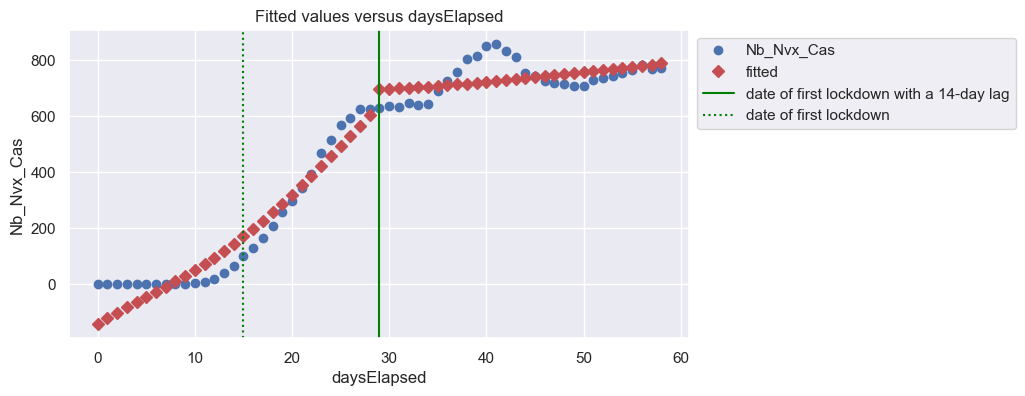

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                              1138.
Date:                Mon, 24 Jul 2023   Prob (F-statistic):                    3.65e-52
Time:                        13:11:31   Log-Likelihood:                         -327.06
No. Observations:                  59   AIC:                                      662.1
Df Residuals:                      55   BIC:                                      670.4
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
daysElapsed           41.0495      3.013     13.622      0.000      35.010      47.089
cutoff              1131.5213     87.386     12.948      0.000     956.395    1306.648
daysElapsed_cutoff   -37.1360      3.237    -11.473      0.000     -43.623     -30.649
stage1_sq           -570.5795     67.537     -8.448      0.000    -705.927    -435.232
==============================================================================
Omnibus:                        6.111   Durbin-Watson:                   0.139
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                4.871
Skew:                           0.591   Prob(JB):                       0.0875
Kurtosis:                       2.236   Cond. No.                         564.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# statsmodels using dataset1
result1 = sm.OLS(y1,X1).fit()

sm.graphics.plot_fit(result1,0,vlines=False)
plt.axvline(29, color="green", label='date of first lockdown with a 14-day lag')
plt.axvline(15, color="green", label='date of first lockdown', linestyle='dotted')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

result1.summary()

In [12]:
X2.head()

,daysElapsed,cutoff,daysElapsed_sq
0,0,0,0
1,1,0,1
2,2,0,4
3,3,0,9
4,4,0,16


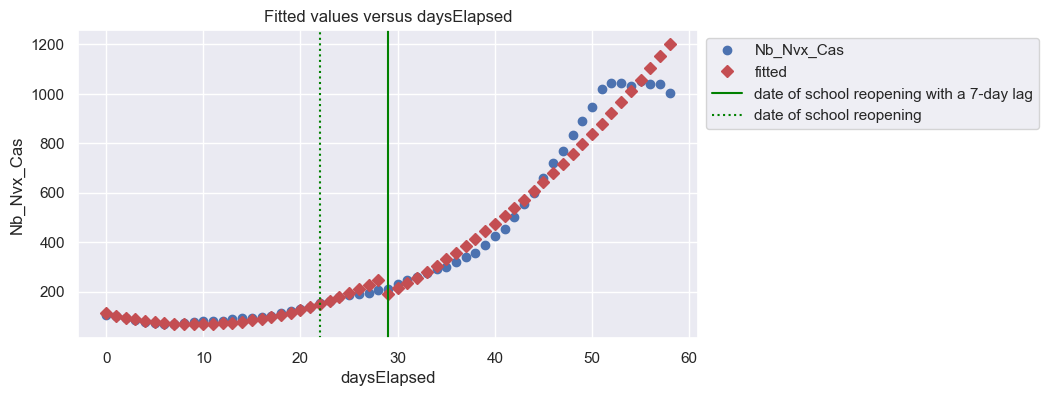

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     816.2
Date:                Mon, 24 Jul 2023   Prob (F-statistic):           1.49e-45
Time:                        13:11:31   Log-Likelihood:                -315.14
No. Observations:                  59   AIC:                             638.3
Df Residuals:                      55   BIC:                             646.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            112.6621     20.899      5.391      0.000      70.780     154.544
daysElapsed       -9.4921      1.746     -5.438      0.000     -12.990      -5.994
cutoff           -72.5120     27.275     -2.659      0.010    -127.173     -17.851
daysElapsed_sq     0.5087      0.026     19.346      0.000       0.456       0.561
==============================================================================
Omnibus:                       12.857   Durbin-Watson:                   0.184
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               37.566
Skew:                          -0.343   Prob(JB):                     6.96e-09
Kurtosis:                       6.848   Cond. No.                     6.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
# statsmodels using dataset2
result2 = sm.OLS(y2,sm.add_constant(X2)).fit()

sm.graphics.plot_fit(result2,1,vlines=False)
plt.axvline(29, color="green", label='date of school reopening with a 7-day lag')
plt.axvline(22, color="green", label='date of school reopening', linestyle='dotted')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

result2.summary()

In [14]:
X3.head()

,daysElapsed,cutoff,daysElapsed_sq,daysElapsed_cutoff
0,0,0,0,0
1,1,0,1,0
2,2,0,4,0
3,3,0,9,0
4,4,0,16,0


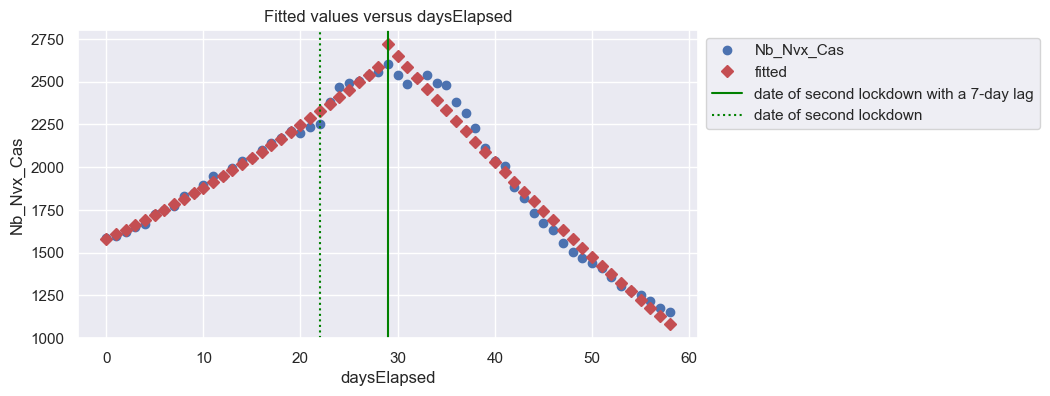

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Nb_Nvx_Cas   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     827.5
Date:                Mon, 24 Jul 2023   Prob (F-statistic):           9.78e-48
Time:                        13:11:32   Log-Likelihood:                -318.49
No. Observations:                  59   AIC:                             647.0
Df Residuals:                      54   BIC:                             657.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1580.9775     24.694     64.022      0.000    1531.469    1630.486
daysElapsed           26.3644      3.382      7.796      0.000      19.585      33.144
cutoff              3351.4595    198.123     16.916      0.000    2954.247    3748.672
daysElapsed_sq         0.3415      0.112      3.039      0.004       0.116       0.567
daysElapsed_cutoff  -112.5795      6.846    -16.444      0.000    -126.305     -98.854
==============================================================================
Omnibus:                        1.331   Durbin-Watson:                   0.359
Prob(Omnibus):                  0.514   Jarque-Bera (JB):                0.700
Skew:                           0.221   Prob(JB):                        0.705
Kurtosis:                       3.300   Cond. No.                     4.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
result3 = sm.OLS(y3,sm.add_constant(X3)).fit()

sm.graphics.plot_fit(result3,1,vlines=False)
plt.axvline(29, color="green", label='date of second lockdown with a 7-day lag')
plt.axvline(22, color="green", label='date of second lockdown', linestyle='dotted')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

result3.summary()

features: ['daysElapsed', 'cutoff', 'daysElapsed_sq', 'daysElapsed_cutoff'] 
coefficients: [ 2.91248864e+01  3.15559443e+03  2.38494236e-01 -1.05771685e+02] 
constant: 1567.1694401576065
RMSE: 54.892412532461414
R_squared:0.9808360843993212


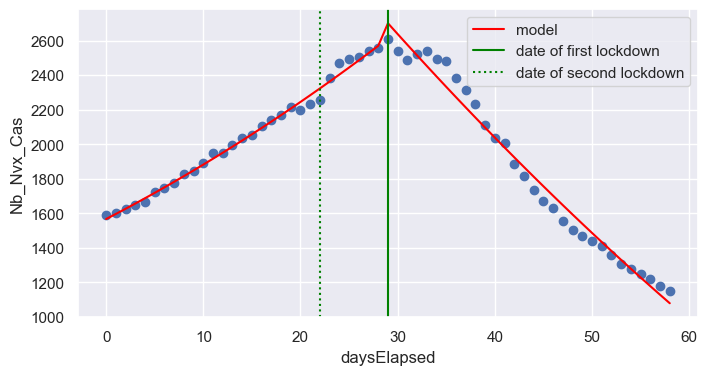

In [16]:
# scikit-learn model using dataset3

from sklearn.model_selection import train_test_split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X3_train, y3_train)

print(f"features: {list(X3_train.columns)} \ncoefficients: {model.coef_} \nconstant: {model.intercept_}")

predictions = model.predict(X3_test)

from sklearn import metrics
RMSE = np.sqrt(metrics.mean_squared_error(y3_test, predictions)) # Root Mean Squared Error
R_squared = metrics.r2_score(y3_test, predictions)
print(f"RMSE: {RMSE}\nR_squared:{R_squared}")

plt.plot(X3['daysElapsed'], model.predict(X3), label='model', color='red')
plt.xlabel('daysElapsed')
plt.ylabel('Nb_Nvx_Cas')
plt.scatter(x=X3['daysElapsed'], y=y3)
plt.axvline(29, color="green", label='date of first lockdown')
plt.axvline(22, color="green", label='date of second lockdown', linestyle='dotted')
plt.legend()
plt.show()